# Diffusion equation on tensorflow

## Imports

In [1]:
import numpy as np
print("numpy=="+str(np.__version__))
import tensorflow as tf
print("tensorflow=="+str(tf.__version__))
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
print("matplotlib=="+str(mpl.__version__))
from platform import python_version
print("python-"+python_version())

numpy==1.15.4
tensorflow==1.12.0
matplotlib==2.1.2
python-3.6.4


## Diffusion Model simulation parameters

In [2]:
tf.reset_default_graph()
print_shape = True 
dims = 2
BOUNDARY_CONDITION = [[1,1],[1,1]]

In [3]:
latticesize = tuple([1000,1000])
density_input = tf.placeholder(tf.float32,latticesize)
minGrad_input = tf.placeholder(tf.float32,latticesize)
MINGRADDENSITY_ = 0
diffCoef_input = tf.placeholder(tf.float32,latticesize)

## Boundary Manipulation

In [4]:
def shift_config(x,dim=0,shift=0,bc=1):
    shifted_x = x
    if shift==1:
        perm = np.arange(0,dims,1) #(0,1,2,3,4,5,6)
        perm[0] = dim #axis to flip dim=3 # (3,1,2,3,4,5,6)
        perm[dim]= 0 # # (3,1,2,0,4,5,6)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([shifted_x[:1], shifted_x[:-1]], axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    if shift==-1:
        perm = np.arange(dims)
        perm[0] = dim
        perm[dim]= 0
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([ shifted_x[1:], shifted_x[-1:] ],axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    return shifted_x

In [5]:
def boundary_config(x,dim=0,shift=0,bc=1):
    shifted_x = x
    if shift==1:
        perm = np.arange(0,dims,1) #(0,1,2,3,4,5,6)
        perm[0] = dim #axis to flip dim=3 # (3,1,2,3,4,5,6)
        perm[dim]= 0 # # (3,1,2,0,4,5,6)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([ 0*shifted_x[1:], bc*shifted_x[-2:-1] ], axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    if shift==-1:
        perm = np.arange(dims)
        perm[0] = dim
        perm[dim]= 0
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
        shifted_x = tf.concat([ bc*(shifted_x[1:2]), 0*shifted_x[:-1] ],axis=0)
        if dim>0:
            shifted_x = tf.transpose(shifted_x,perm)
    return shifted_x

## Update

In [6]:
def grad_persite(f,D,B,bmask,print_shape=False):
    df_dt = 0*f
    for d in range(dims):
        for s in [-1,1]:
            df_dxi = (shift_config(f,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s])-f)
            if MINGRADDENSITY_>0:
                B_i = B + shift_config(B,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s])
                df_dxi = tf.where(tf.abs(df_dxi)<B_i, 0*B_i, df_dxi)
                df_dxi = tf.where(df_dxi>B_i, df_dxi-B_i, df_dxi)
                df_dxi = tf.where(df_dxi<-B_i, df_dxi+B_i, df_dxi)
            D_shifted = shift_config(D,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s])
            df_dxi = df_dxi * (D + D_shifted)/2
            df_dxi = df_dxi * bmask
            if BOUNDARY_CONDITION[d][s]>0:
                df_dxi = df_dxi + boundary_config(df_dxi,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s])
            df_dt = df_dt + df_dxi
    if print_shape: print("Gradient:"+str(df_dt.shape))
    return df_dt

In [7]:
def update(f,D,B,bmask,dt):
    df = dt*grad_persite(f,D,B,bmask)
    y = f+df
    return tf.stack([y,df])

In [8]:
def evolve_step(f,D,B,bmask,dt,n=100):
    bcmask = bmask*0+1
    for d in range(dims):
        for s in [-1,1]:
            if BOUNDARY_CONDITION[d][s]>0:
                f = f * (1-boundary_config(bcmask,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s]))
                f = f + boundary_config(f,dim=d,shift=s,bc=BOUNDARY_CONDITION[d][s])
    densityout = [[f,f*0]]
    for i in range(n): 
        y = update(densityout[-1][0],D,B,bmask,dt)
        densityout.append(y)
    return densityout

In [9]:
%%time
ddt_input = tf.placeholder(tf.float32)
boundary_mask = tf.ones(latticesize,tf.float32)
for d in range(dims):
    for s in [-1,1]:
        boundary_mask = boundary_mask + boundary_config(boundary_mask,dim=d,shift=s,bc=1)
boundary_mask = tf.where(boundary_mask>1,boundary_mask*0,boundary_mask)
density_outputs = evolve_step(density_input,diffCoef_input,minGrad_input,boundary_mask,ddt_input)

CPU times: user 10.9 s, sys: 251 ms, total: 11.2 s
Wall time: 11.2 s


In [10]:
def evolve_best_ddt(D,dt=1):
    ddt = dt
    subt = int(np.ceil(2*2*dims*np.max(D)*ddt))
    subt = subt if subt>0 else 1
    ddt /= subt
    return ddt,subt
def steadyState_best_ddt(D):
    subt = (2*2*dims*np.max(D))
    ddt = 1/subt if subt>0 else 1
    return ddt

In [11]:
try:
    sess.close()
    print("Closing previous open session")
except NameError:
    print("No previous session open")
    
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

No previous session open


# Simulate

In [18]:
density = np.random.rand(*latticesize)+0.5
# density[:1,:] = 1
# density[-1:,:] = 1
# density[:,-1:] = 0
# density[:,:1] = 2
diffCoef = np.random.rand(*latticesize)+1
diffCoef = np.random.normal(4,2,size=latticesize)
diffCoef = np.where(diffCoef<0,0,diffCoef)+1
minGrad = np.random.rand(*latticesize)*0

1 TF eval: dt=0.8736891804545575: ddt:0.008736891804545574, n:100


<IPython.core.display.Javascript object>


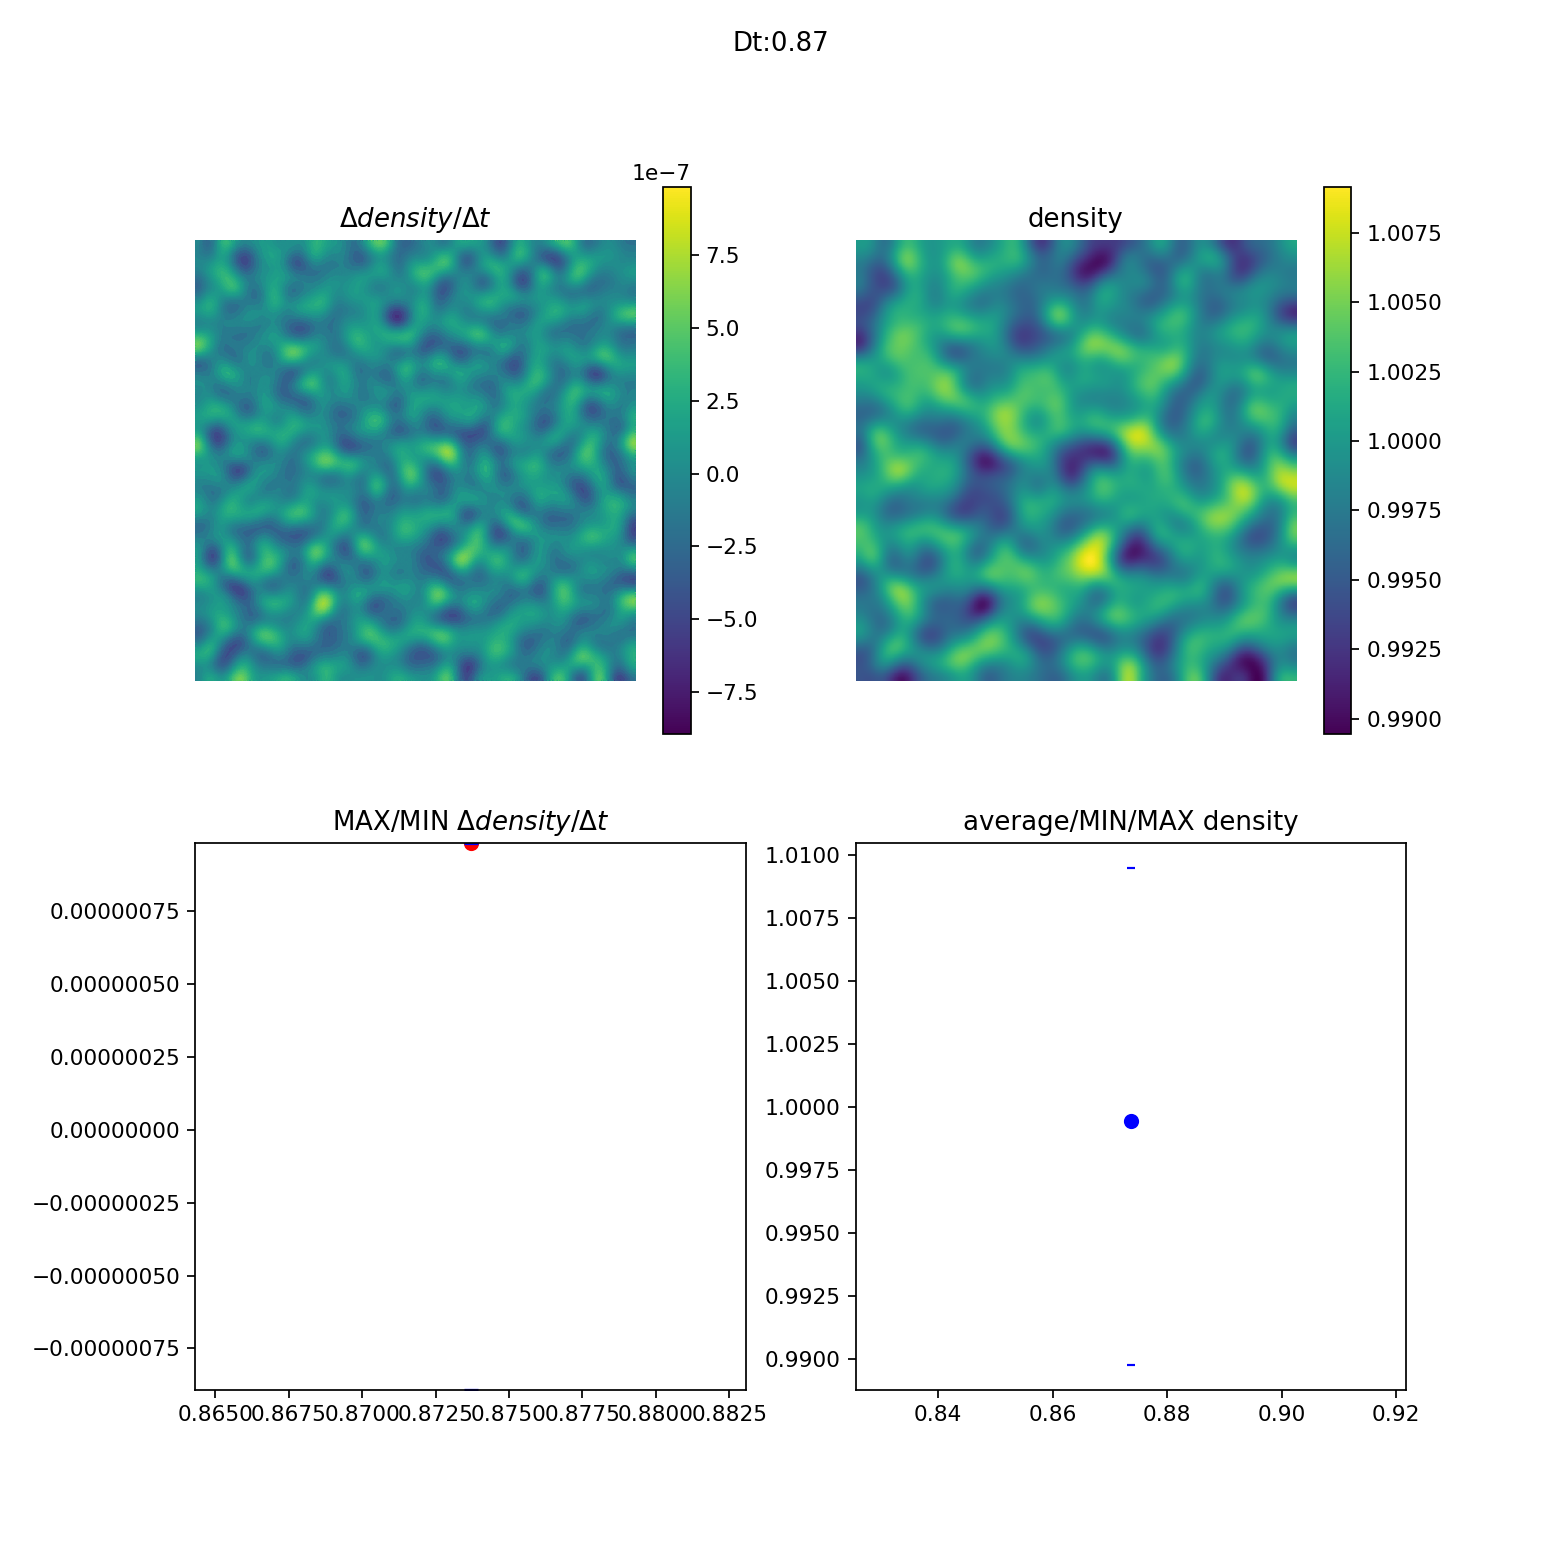

Dt:0.8737, df:9.8345e-07  Done!
CPU times: user 710 ms, sys: 36.9 ms, total: 747 ms
Wall time: 740 ms


In [20]:
%%time
import time
# t_start = time.time()
# x_,y_ = np.linspace(-2,2,1000),np.linspace(-2,2,1000)
# xx,yy = np.meshgrid(x_,y_)
# density = np.exp(-(xx**2+yy**2)/2)

# ddt,subt = evolve_best_ddt(diffCoef,dt=dt)
ddt = steadyState_best_ddt(diffCoef)
subt = 100
dt = ddt*subt
print(f"1 TF eval: dt={dt}: ddt:{ddt}, n:{subt}")

Dt = 0

fig,ax = plt.subplots(2,2,figsize=(10,10))
plt.ion()
ax[0,0].cla()
ax[0,1].cla()
ax[1,0].cla()
ax[1,1].cla()
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,0].set_title("$\Delta density/\Delta t$")
ax[0,1].set_title("density")
ax[1,0].set_title(f"MAX/MIN $\Delta density/\Delta t$")
ax[1,1].set_title(f"average/MIN/MAX density")
fig.suptitle(f"Dt:{Dt:.2f}")
cax0 = ax[0,0].imshow(diffCoef[1:-1,1:-1])
cb0 = fig.colorbar(cax0,ax=ax[0,0])
cax1 = ax[0,1].imshow(density[1:-1,1:-1])
cb1 = fig.colorbar(cax1,ax=ax[0,1])
# ax[1,0].set_yscale('log')
fig.canvas.draw()
plt.pause(0.0001)
precision = 0.000001
dfabsmax = 1
# print(time.time()-t_start,"seconds")
print("\r"+"Dt:"+str(Dt),end='  ',flush=True)
vmin = None
vmax = None
i= 0 
while precision<dfabsmax:
    try:
        density,dfi = density_outputs[subt].eval(feed_dict={density_input:density, 
                                                            ddt_input: ddt, 
                                                            diffCoef_input: diffCoef,
                                                            minGrad_input: minGrad
                                                           })
        
        dfmax = np.max(dfi[1:-1,1:-1])
        dfmin = np.min(dfi[1:-1,1:-1])
        if type(vmin)==type(None):
            vmin =  dfmin
            vmax =  dfmax
        dfabsmax = np.max([np.abs(dfmax),np.abs(dfmin)])
        fmean= np.mean(density[1:-1,1:-1])
        fmax= np.max(density[1:-1,1:-1])
        fmin= np.min(density[1:-1,1:-1])
        Dt += ddt*subt
        if i%100==0 or precision<dfabsmax:
            ax[0,0].cla()
            ax[0,1].cla()
            ax[0,0].axis('off')
            ax[0,1].axis('off')
            ax[0,0].set_title("$\Delta density/\Delta t$")
            ax[0,1].set_title("density")
            fig.suptitle(f"Dt:{Dt:.2f}")
            ax[0,0].imshow(dfi)
            cb0.set_clim(dfmin,dfmax)
            cb0.draw_all()
            ax[0,1].imshow(density[1:-1,1:-1])
            cb1.set_clim(fmin,fmax)
            cb1.draw_all()
            ax[1,0].set_ylim(vmin,vmax)
            ax[1,0].scatter(Dt,dfabsmax,c='r')
            ax[1,0].scatter(Dt,dfmin,c='b',marker="_")
            ax[1,0].scatter(Dt,dfmax,c='b',marker="_")
            ax[1,1].errorbar([Dt],[fmean],yerr=[[fmax-fmean],[fmean-fmin]],c='b',fmt='o',elinewidth=0.00001,capsize=2)
            fig.canvas.draw()
            plt.pause(0.0001)
            print("\r"+f"Dt:{Dt:.4f}, df:{dfabsmax:.4e}",end='  ',flush=True)
        i+=1
    except KeyboardInterrupt:
        print('Interupted')
        break
print("\r"+f"Dt:{Dt:.4f}, df:{dfabsmax:.4e}",end='  Done!\n',flush=True)
